# Book Recommender System
Book recommendation system using **Collaborative Filtering** algorithm

In [108]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from skimage import io

## 1. Loading the dataset
The dataset is the **book dataset** on kaggle, accessed through this <a href="https://www.kaggle.com/datasets/ra4u12/bookrecommendation?resource=download">link</a>  
*The dataset contains 3 `csv` files*:
- `BX-Books`: contains all the information about the book such as 
    * ISBN
    * Title
    * Author
    * Year
    * Cover (link to picture)
- `BX-Users`: contains all the information about the users such as  
    * User ID
    * Age
    * Location
- `BX-Book-Ratings`: ties the *User-ID* and the *ISBN* of the book with the given rating 


In [110]:
# load the data files
books_data = pd.read_csv("data/BX-Books.csv", sep=";", on_bad_lines='skip', encoding="latin-1")
users_data = pd.read_csv("data/BX-Users.csv", sep=";", on_bad_lines='skip', encoding="latin-1")
ratings_data = pd.read_csv("data/BX-Book-Ratings.csv", sep=";", on_bad_lines='skip', encoding="latin-1")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1504904\4278068128.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_data = pd.read_csv("data/BX-Books.csv", sep=";", on_bad_lines='skip', encoding="latin-1")


In [111]:
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [112]:
users_data.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [113]:
ratings_data.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Data Cleaning
In all of our DFs we need to check for:
- duplicates
- nulls  
  
and then remove them   
    
**For the `books_data`**  
* Removing unnecessary features like the small and medium image links - we only keep the *large* ones to use in our UI  
* Renaming complicated column titles like `Book-title` to just `title` and so on

In [114]:
def clean_data(data):
    "removes nulls and duplicates and returns a clean dataframe"
    print("number of null values: ", data.isna().sum())
    clean_data = data.dropna(inplace=False)
    print("number of duplicated records: ", sum(clean_data.duplicated()))
    clean_data = clean_data.drop_duplicates()
    return clean_data

In [115]:
users_data = clean_data(users_data)
books_data = clean_data(books_data)
ratings_data = clean_data(ratings_data)

number of null values:  User-ID          0
Location         0
Age         110762
dtype: int64
number of duplicated records:  0
number of null values:  ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
number of duplicated records:  0
number of null values:  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
number of duplicated records:  0


In [116]:
# cleaning the books dataframe
# removing unnecessary features
books_data = books_data.drop(['Image-URL-S','Image-URL-M'], axis=1)
# renaming complicated colums
books_data.rename(columns={
    'Book-Title': "Title",
    'Book-Author': 'Author',
    'Year-Of-Publication': 'Year',
    'Image-URL-L': 'Image'
}, inplace=True)
books_data.head()

,ISBN,Title,Author,Year,Publisher,Image
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [117]:
# rename complicated columns in the ratings dataframe too
ratings_data.rename(columns={
    "User-ID": "User",
    "Book-Rating": "Rating"
}, inplace=True)
ratings_data.head()

,User,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


#### Getting some info abbout our dataset

In [118]:
# get some stats about the data
print(f"users' data shape: {users_data.shape}")
print(f"books' data shape: {books_data.shape}")
print(f"ratings' data shape: {ratings_data.shape}")

users' data shape: (168096, 3)
books' data shape: (271353, 6)
ratings' data shape: (1149780, 3)


In [119]:
print(f"number of unique users = {len(ratings_data['User'].unique())}")
print(f"number of books which have a rating = {len(ratings_data['ISBN'].unique())}")

number of unique users = 105283
number of books which have a rating = 340556


So we know we have **105283** users rating **340556** books

In [120]:
print(f"range of values of the ratings are {sorted(ratings_data['Rating'].unique())}")

range of values of the ratings are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


#### Filtering the data
The dataset size is huge we have over `1m` ratings and some users may have only rated 1 or 2 or even 10 books, so we want to keep only the users who have rated more than **200** books

In [121]:
# create the mask to take the users with more than 
mask = ratings_data['User'].value_counts()>200
y = mask[mask].index
ratings_data = ratings_data[ratings_data['User'].isin(y)]
ratings_data.head()

,User,ISBN,Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [122]:
ratings_data.shape

(526356, 3)

#### Merging the dataframes
we want to merge the books based on the *ISBN* <!-- and the user data based on the *User ID* -->

In [123]:
dataset = ratings_data.merge(books_data, on="ISBN")

In [124]:
print(f"reduced data size = {dataset.shape}")
print(f"nbr of users who gave a rating = {len(dataset['User'].unique())}")

reduced data size = (487665, 8)
nbr of users who gave a rating = 899


### Feature engineering
Creating a new feature which is *number of ratings each movie has*

In [125]:
# create a small dataframe with the book name and its nbr of ratings rating 
rated_books = dataset.groupby("Title")['Rating'].count().reset_index()
rated_books.rename(columns={'Rating': 'nbr_ratings'}, inplace=True)
rated_books.head()

,Title,nbr_ratings
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [126]:
# now we add this new feature here
dataset = dataset.merge(rated_books, on="Title")
dataset.head()

,User,ISBN,Rating,Title,Author,Year,Publisher,Image,nbr_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82


#### Filtering the data
We need to filter out the books that have less than `50` ratings

In [127]:
dataset = dataset[dataset['nbr_ratings']>=50]
dataset.head()

,User,ISBN,Rating,Title,Author,Year,Publisher,Image,nbr_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82


## 2. Pivot Table
we need to create the matrix with the movies and the ratings

In [128]:
book_pivot = dataset.pivot_table(columns='User', index='Title', values='Rating')

This pivot table will be incredibly sparse because there are so many non rated books by the user, we can't leave them empty or `NaN` so we will fill those cells with `zeros`

In [129]:
print(book_pivot.shape)
# replace nan values with 0
book_pivot.fillna(0, inplace=True)

(742, 888)


In [130]:
from scipy.sparse import csr_matrix
# create sparse matrix using the pivot table
book_sparse = csr_matrix(book_pivot)
print(book_sparse)

  (0, 0)	9.0
  (0, 16)	8.0
  (0, 26)	3.3333333333333335
  (0, 37)	9.0
  (0, 42)	8.0
  (0, 59)	7.0
  (0, 135)	9.0
  (0, 156)	10.0
  (0, 170)	9.0
  (0, 187)	8.0
  (0, 220)	10.0
  (0, 221)	10.0
  (0, 245)	5.0
  (0, 277)	10.0
  (0, 359)	10.0
  (0, 370)	9.0
  (0, 389)	10.0
  (0, 477)	9.0
  (0, 491)	7.0
  (0, 507)	9.0
  (0, 554)	10.0
  (0, 604)	9.0
  (0, 611)	8.0
  (0, 695)	9.0
  (0, 734)	9.0
  :	:
  (741, 16)	8.0
  (741, 26)	3.5
  (741, 86)	10.0
  (741, 103)	2.5
  (741, 111)	5.0
  (741, 150)	6.0
  (741, 233)	7.0
  (741, 290)	8.0
  (741, 303)	9.0
  (741, 322)	10.0
  (741, 367)	10.0
  (741, 384)	9.0
  (741, 446)	7.0
  (741, 450)	9.0
  (741, 485)	7.0
  (741, 490)	3.0
  (741, 498)	10.0
  (741, 505)	8.0
  (741, 544)	10.0
  (741, 592)	8.0
  (741, 700)	10.0
  (741, 713)	8.0
  (741, 745)	10.0
  (741, 830)	9.0
  (741, 880)	8.0


## 3. Define the model
we will use the created `sparse matrix` to pass it to the nearest neighbor algorithm to group similar books together based on user ratings and so the clusters will have books of nearly the same genre *(to a certain degree)*

In [131]:
from sklearn.neighbors import NearestNeighbors

# instantiate the model
knn = NearestNeighbors(algorithm='brute')
# train the model
knn.fit(book_sparse)
# the model returns the distance of the suggestion to the passed book and the most similar
# exemple
distance, suggestion = knn.kneighbors(book_pivot.iloc[237,:].values.reshape(1,-1), n_neighbors=6)

In [132]:
for i in range(len(suggestion)):
    print(book_pivot.index[suggestion[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive',
       'Jacob Have I Loved'],
      dtype='object', name='Title')


### Saving the model and other data for the UI

In [133]:
# get book names from the pivot table for the web application
book_names = book_pivot.index
# save the model 
import pickle
# pickle.dump(knn, open('artifacts/model.pkl', 'wb'))
# pickle.dump(book_names, open('artifacts/book_names.pkl', 'wb'))
# pickle.dump(dataset, open('artifacts/dataset.pkl', 'wb'))
# pickle.dump(book_pivot, open('artifacts/book_pivot.pkl', 'wb'))
# pickle.dump(books_data, open('artifacts/book_data.pkl', 'wb'))

### Inference
Recommendation process:   
*Given a book name:*
- we will look for its index 
- pass the index to the model to find its nearest neighbors
- take the suggestions array and fetch the names of the suggested books from the pivot table

In [134]:
import urllib.request
from PIL import Image
import io as sio

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

def recommend_books(name):
    """A function to use our model to recommend its most similar books using collaborative filtering"""
    # fetch book id from the pivot table 
    book_id = list(book_pivot.index).index(name)
    # make the prediction to get the suggestions
    _ , suggestions = knn.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=6)

    # get the names of the suggested books 
    for i, suggestion in enumerate(suggestions[0]):
        # get the suggested book name
        book_name = book_pivot.index[suggestion] 
        
        # get the cover of the book
        cover_url = list(books_data['Image'])[list(books_data['Title']).index(book_name)]
        req = urllib.request.Request(cover_url, headers=headers)
        # book_cover = io.imread(cover_url)
        with urllib.request.urlopen(req) as response:
            image_data = response.read()
        book_cover = np.array(Image.open(sio.BytesIO(image_data)))
        # plot the cover of the book with its title
        plt.subplot(1, 6, i+1)
        plt.imshow(book_cover)
        plt.title(book_name)
        plt.axis('off')
    
    plt.show()
        

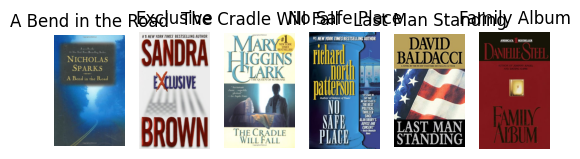

In [135]:
sample_name = "A Bend in the Road"
recommend_books(sample_name)